### Imports

In [14]:
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils_go import *

# import hdbscan
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pingouin as pg
import sys
import time

# %load_ext autotime

### Parameters

In [15]:
file = open("exp.json")
experiment = json.load(file)
exp_num = experiment["exp"]

file = open("output/{}/parameters.json".format(exp_num))
params = json.load(file)

exp = params["exp"]
print("Exp:\t\t", exp)

method = "greedy"
print("Method:\t\t", method)

data_variations = ["none"]
print("Data variations:", data_variations)

threshold_corr = params["threshold_corr"]
print("Threshold corr:\t", threshold_corr)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

Exp:		 exp65
Method:		 greedy
Data variations: ['none']
Threshold corr:	 0.3
Groups id:	 ['WT-YNB', 'S51A-YNB', 'WT-Tyr', 'S51A-Tyr', 'WT-total', 'WT-vac', 'avt1-total', 'avt1-vac', 'aa-standard']
Subgroups id:	 {'WT-YNB': ['1', '2'], 'S51A-YNB': ['1', '2'], 'WT-Tyr': ['1', '2'], 'S51A-Tyr': ['1', '2'], 'WT-total': ['1', '2'], 'WT-vac': ['1', '2'], 'avt1-total': ['1', '2'], 'avt1-vac': ['1', '2'], 'aa-standard': ['1', '2']}


### Get common subgraphs

In [16]:
# read edges
start = time.time()

dict_graphs = {}

for group in tqdm(groups_id):
    graphs = []
    for subgroup in tqdm(subgroups_id[group]):
        df_edges = pd.read_csv("output/{}/preprocessing/edges/edges_{}_{}.csv".format(exp, group, subgroup))
        G = nx.from_pandas_edgelist(df_edges, "source", "target", edge_attr="weight")
        # graph_detail(G)
        graphs.append(G)

        print(group, subgroup)
        # graph_partial_detail(G, edges=True)
    
    dict_graphs[group] = graphs

100%|██████████| 2/2 [00:00<00:00, 113.65it/s]


WT-YNB 1
WT-YNB 2


100%|██████████| 2/2 [00:00<00:00, 127.48it/s]


S51A-YNB 1
S51A-YNB 2


100%|██████████| 2/2 [00:00<00:00, 126.38it/s]


WT-Tyr 1
WT-Tyr 2


100%|██████████| 2/2 [00:00<00:00, 124.64it/s]


S51A-Tyr 1
S51A-Tyr 2


100%|██████████| 2/2 [00:00<00:00, 124.85it/s]


WT-total 1
WT-total 2


 67%|██████▋   | 6/9 [00:00<00:00, 56.40it/s]

WT-vac 1
WT-vac 2


100%|██████████| 2/2 [00:00<00:00, 125.17it/s]


avt1-total 1
avt1-total 2


100%|██████████| 2/2 [00:00<00:00, 120.70it/s]


avt1-vac 1
avt1-vac 2


100%|██████████| 9/9 [00:00<00:00, 56.23it/s]

aa-standard 1
aa-standard 2


In [17]:
# get subgraphs

dict_df_edges_filter = get_subgraphs_global(dict_graphs, groups_id)


end = time.time()
elapsed = end - start

print("Runtime:", elapsed)

100%|██████████| 1/1 [00:00<00:00, 109.59it/s]


Num. nodes: 110
Num. edges: 5995



100%|██████████| 1/1 [00:00<00:00, 108.98it/s]


Num. nodes: 109
Num. edges: 5886



100%|██████████| 1/1 [00:00<00:00, 113.03it/s]

Num. nodes: 109
Num. edges: 5886




 44%|████▍     | 4/9 [00:00<00:00, 35.98it/s]

Num. nodes: 111
Num. edges: 6105



100%|██████████| 1/1 [00:00<00:00, 111.59it/s]

Num. nodes: 109
Num. edges: 5886




100%|██████████| 1/1 [00:00<00:00, 107.51it/s]


Num. nodes: 111
Num. edges: 6105



100%|██████████| 1/1 [00:00<00:00, 110.71it/s]


Num. nodes: 109
Num. edges: 5886



 89%|████████▉ | 8/9 [00:00<00:00, 35.66it/s]

Num. nodes: 111
Num. edges: 6105



100%|██████████| 9/9 [00:00<00:00, 35.67it/s]

Num. nodes: 111
Num. edges: 6105

Runtime: 0.4329802989959717


In [18]:
df_edges_filter = dict_df_edges_filter[groups_id[0]]
df_edges_filter.head()

,source,target
0,13,88
1,13,101
2,13,22
3,13,35
4,13,77


### New correlation

In [19]:
# read raw data
df_join_raw = pd.read_csv("input/{}_raw.csv".format(exp), index_col=0)
# df_join_raw.index = df_join_raw.index.astype("str")
df_join_raw = df_join_raw.iloc[:, 2:]
df_join_raw

,WT-YNB_1.1,WT-YNB_1.2,WT-YNB_2.1,WT-YNB_2.2,S51A-YNB_1.1,S51A-YNB_1.2,S51A-YNB_2.1,S51A-YNB_2.2,WT-Tyr_1.1,WT-Tyr_1.2,...,avt1-total_2.1,avt1-total_2.2,avt1-vac_1.1,avt1-vac_1.2,avt1-vac_2.1,avt1-vac_2.2,aa-standard_1.1,aa-standard_1.2,aa-standard_2.1,aa-standard_2.2
0,6.508331e+04,5.510899e+04,6.418729e+04,5.865636e+04,7.023975e+04,6.072488e+04,6.418729e+04,7.221445e+04,1.956712e+06,1.956712e+06,...,1.174696e+04,1.207721e+04,1.276583e+04,1.096030e+04,1.233098e+04,1.096030e+04,1.301666e+05,1.197777e+05,1.454335e+05,1.197777e+05
1,3.780118e+06,3.702325e+06,6.536106e+06,6.313462e+06,3.995653e+06,3.601084e+06,3.268053e+06,3.478418e+06,4.919226e+06,6.627347e+06,...,8.928584e+06,1.689391e+07,1.282031e+06,1.813066e+06,4.023445e+06,1.813066e+06,1.171560e+06,9.516028e+05,1.005861e+06,9.516028e+05
2,7.508014e+06,6.226543e+06,5.572912e+06,6.861060e+06,6.269852e+06,5.931642e+06,6.056278e+06,6.627347e+06,1.535205e+06,1.600399e+06,...,2.097152e+06,2.294900e+06,2.767209e+06,2.617939e+06,2.511295e+06,2.617939e+06,4.564192e+05,5.029307e+05,4.692509e+05,5.029307e+05
3,2.294900e+06,2.186209e+06,2.294900e+06,2.082666e+06,2.111739e+06,2.068280e+06,1.970322e+06,1.997827e+06,2.493948e+06,2.408995e+06,...,3.891589e+05,5.503539e+05,5.390277e+05,6.191803e+05,6.321906e+05,6.191803e+05,5.465523e+05,4.288162e+05,4.857990e+05,4.288162e+05
4,4.439384e+05,3.435118e+05,4.408719e+05,5.029307e+05,3.411390e+05,4.170902e+05,3.891589e+05,4.000997e+05,4.199913e+05,5.206665e+05,...,9.128384e+05,1.432397e+06,1.301666e+05,1.569559e+05,4.932393e+04,1.569559e+05,2.301042e+04,2.432243e+04,2.059491e+04,2.432243e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,1.975596e+04,3.511987e+04,4.445321e+04,2.994443e+04,2.643204e+04,3.322542e+04,2.832916e+04,2.317048e+04,4.205530e+04,2.365734e+04,...,5.825119e+04,8.829230e+04,9.255812e+05,1.131653e+06,9.128384e+05,1.131653e+06,1.103654e+04,1.051382e+04,1.015569e+04,1.051382e+04
108,2.957167e+03,5.042768e+03,3.350127e+03,4.299640e+03,3.983995e+03,1.396957e+04,1.029745e+04,1.199379e+04,5.007935e+03,4.973342e+03,...,2.102765e+04,6.330360e+04,5.397486e+04,2.793914e+04,1.895118e+04,2.793914e+04,3.104188e+03,2.936740e+03,3.213656e+03,2.936740e+03
109,3.041062e+08,2.665812e+08,2.135502e+08,2.703026e+08,3.591472e+08,3.148305e+08,3.743987e+08,3.350962e+08,1.552481e+08,1.418706e+08,...,8.435674e+07,8.978680e+07,1.448516e+08,1.296458e+08,1.296458e+08,1.296458e+08,1.541757e+08,1.370379e+08,1.428573e+08,1.370379e+08
110,1.240017e+05,1.021267e+05,1.301666e+05,9.528754e+04,1.189504e+05,9.268190e+04,1.000249e+05,9.661771e+04,1.035523e+05,9.332655e+04,...,2.483350e+04,2.333164e+04,2.266332e+05,3.507297e+05,2.549757e+05,3.507297e+05,2.071046e+05,1.042726e+05,1.869027e+04,1.042726e+05


In [20]:
# log10
df_join_raw_log = log10_global(df_join_raw)
df_join_raw_log.head()

,WT-YNB_1.1,WT-YNB_1.2,WT-YNB_2.1,WT-YNB_2.2,S51A-YNB_1.1,S51A-YNB_1.2,S51A-YNB_2.1,S51A-YNB_2.2,WT-Tyr_1.1,WT-Tyr_1.2,...,avt1-total_2.1,avt1-total_2.2,avt1-vac_1.1,avt1-vac_1.2,avt1-vac_2.1,avt1-vac_2.2,aa-standard_1.1,aa-standard_1.2,aa-standard_2.1,aa-standard_2.2
0,4.813470,4.741222,4.807449,4.768315,4.846583,4.783367,4.807449,4.858624,6.291527,6.291527,...,4.069926,4.081967,4.106049,4.039823,4.090998,4.039823,5.114500,5.078376,5.162664,5.078376
1,6.577505,6.568475,6.815319,6.800268,6.601588,6.556433,6.514289,6.541382,6.691897,6.821340,...,6.950783,7.227730,6.107899,6.258414,6.604598,6.258414,6.068765,5.978456,6.002538,5.978456
2,6.875525,6.794247,6.746082,6.836391,6.797257,6.773175,6.782206,6.821340,6.186166,6.204228,...,6.321630,6.360764,6.442042,6.417960,6.399898,6.417960,5.659364,5.701508,5.671405,5.701508
3,6.360764,6.339692,6.360764,6.318620,6.324640,6.315609,6.294537,6.300558,6.396887,6.381836,...,5.590127,5.740642,5.731611,5.791817,5.800848,5.791817,5.737632,5.632271,5.686457,5.632271
4,5.647323,5.535942,5.644312,5.701508,5.532931,5.620230,5.590127,5.602168,5.623240,5.716560,...,5.960394,6.156063,5.114500,5.195778,4.693058,5.195778,4.361925,4.386007,4.313760,4.386007


In [21]:
# correlation
dict_df_corr = {}
for group in tqdm(groups_id):
    # graph filter
    df_edges_filter = dict_df_edges_filter[group]
    G = nx.from_pandas_edgelist(df_edges_filter.iloc[:, [0, 1]])
    nodes = list(G.nodes())
    
    df_join_raw_filter = df_join_raw_log.loc[nodes, :]
    # df_join_raw_filter = df_join_raw_filter.filter(regex=group, axis=1)
    df_join_raw_filter = df_join_raw_filter.filter(like=group, axis=1)

    df_join_raw_filter_t= df_join_raw_filter.T
    # df_join_raw_filter_corr = df_join_raw_filter_t.corr(method="pearson")
    df_join_raw_filter_corr = pg.pcorr(df_join_raw_filter_t)
    dict_df_corr[group] = df_join_raw_filter_corr

100%|██████████| 9/9 [00:00<00:00, 113.24it/s]


In [22]:
# get new correlation
dict_df_edges_filter_weight = {}
for group in tqdm(groups_id):
    df_edges_filter_weight = dict_df_edges_filter[group].copy()
    df_corr = dict_df_corr[group]
    
    df_edges_filter_weight["weight"] = df_edges_filter_weight.apply(lambda x: df_corr.loc[x["source"], x["target"]], axis=1)
    df_edges_filter_weight.sort_values(["source", "target"], ascending=True, inplace=True)
    dict_df_edges_filter_weight[group] = df_edges_filter_weight
    # df_edges_filter_weight.to_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, option), index=False)

    print(group)
    G = nx.from_pandas_edgelist(dict_df_edges_filter_weight[group], "source", "target", edge_attr="weight")
    # graph_partial_detail(G, edges=True)

 44%|████▍     | 4/9 [00:00<00:00, 16.58it/s]

WT-YNB
S51A-YNB
WT-Tyr
S51A-Tyr


 89%|████████▉ | 8/9 [00:00<00:00, 17.24it/s]

WT-total
WT-vac
avt1-total
avt1-vac


100%|██████████| 9/9 [00:00<00:00, 16.88it/s]

aa-standard


In [23]:
df_edges_filter_weight = dict_df_edges_filter_weight[groups_id[0]]
df_edges_filter_weight

,source,target,weight
5263,0,7,0.711007
5288,0,11,0.599148
5259,0,14,-0.869013
5257,0,19,-0.975574
5287,0,22,-0.226619
...,...,...,...
3441,110,105,0.826994
3454,110,108,0.882559
3445,110,111,-0.441450
5993,111,66,0.499887


In [24]:
# filter by abs(weight) >= threshold
for group in tqdm(groups_id):
    df_edges_filter_weight = dict_df_edges_filter_weight[group]
    df_edges_filter_weight_filter = df_edges_filter_weight[df_edges_filter_weight["weight"].abs() >= threshold_corr]
    df_edges_filter_weight_filter.to_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, data_variations[0]), index=False)

100%|██████████| 9/9 [00:00<00:00, 178.86it/s]


In [25]:
df_edges_filter_weight_filter = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, groups_id[0], data_variations[0]))
df_edges_filter_weight_filter

,source,target,weight
0,0,7,0.711007
1,0,11,0.599148
2,0,14,-0.869013
3,0,19,-0.975574
4,0,28,0.915602
...,...,...,...
4419,110,105,0.826994
4420,110,108,0.882559
4421,110,111,-0.441450
4422,111,66,0.499887


WT-YNB
N° nodes:  6
N° edges:  11


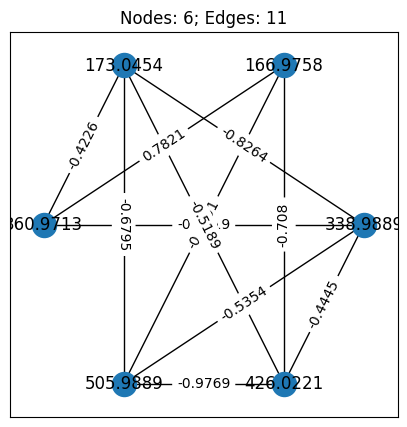

S51A-YNB
N° nodes:  6
N° edges:  10


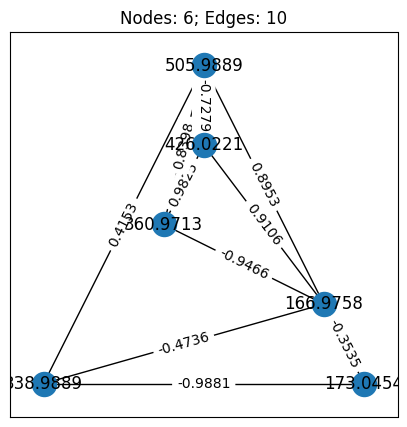

WT-Tyr
N° nodes:  5
N° edges:  9


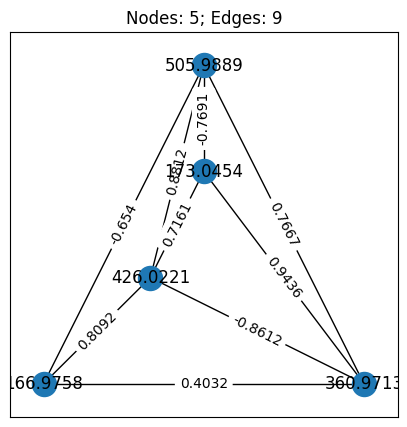

S51A-Tyr
N° nodes:  5
N° edges:  6


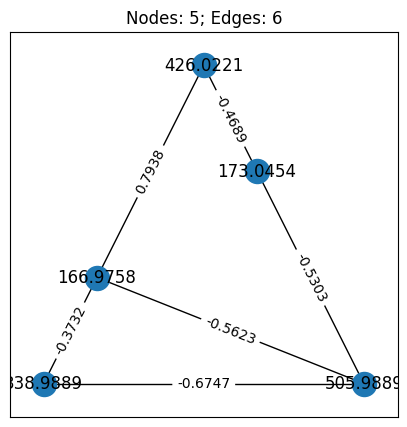

WT-total
N° nodes:  6
N° edges:  13


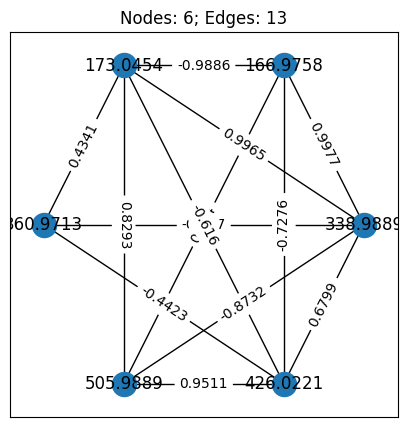

WT-vac
N° nodes:  6
N° edges:  14


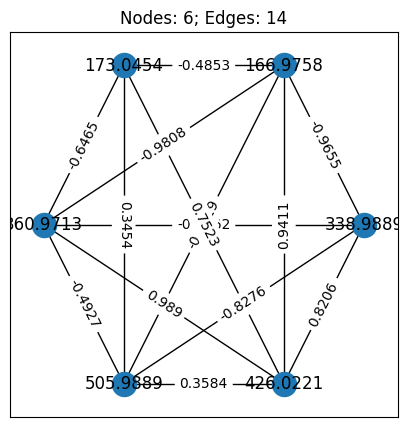

avt1-total
N° nodes:  6
N° edges:  15


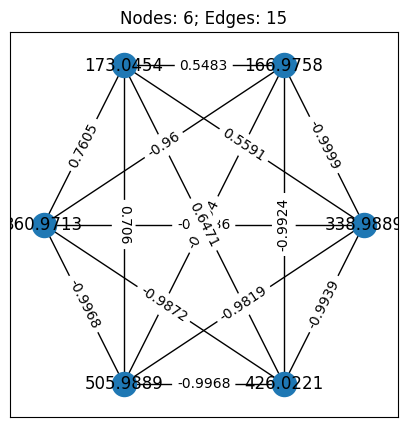

avt1-vac
N° nodes:  6
N° edges:  12


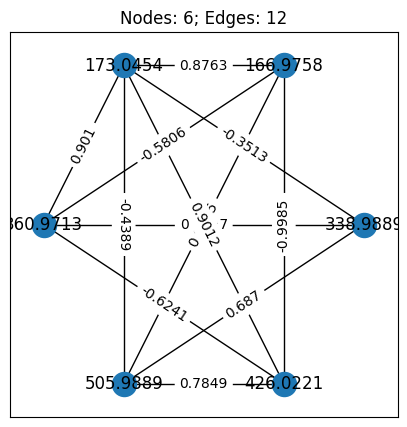

aa-standard
N° nodes:  6
N° edges:  13


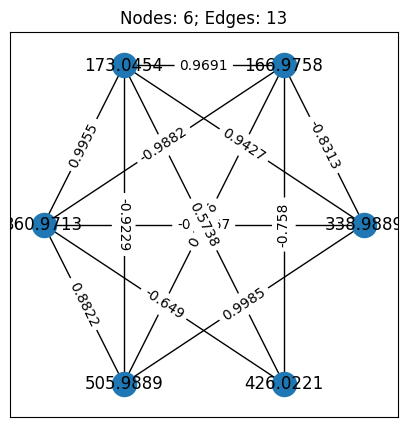

In [26]:
# final greedy
for k, group in enumerate(groups_id):
    df_edges_filter_weight_filter = pd.read_csv("output/{}/common_edges/common_edges_{}_{}_{}.csv".format(exp, method, group, data_variations[0]))
    # print(df_edges_filter_weight_filter)

    G = nx.from_pandas_edgelist(df_edges_filter_weight_filter, edge_attr=["weight"])
    print(group)
    graph_partial_detail(G, edges=True)